## Plot climatological zonal-mean total column ozone

Comparing the CCMI2022 ensemble mean against the ensemble members and the nudged UM-UKCA ACSIS data.

In [1]:
# need to import cfplot before cf due to issues with matplotlib and esmpy
import cfplot as cfp
import cf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# define the locations of the various datasets
# CCMI2022 refD1 ensemble
ensdata='/home/ubuntu/Tutorials/UMvn13.0/data/toz_Amon_UKESM1-StratTrop_refD1_r*i1p1f2_gn_19600101-20190101.nc'
# CCMI1 refC1
ccmidata='/home/ubuntu/Tutorials/UMvn13.0/data/toz_monthly_UMUKCA-UCAM_refC1_r1i1p1_*.nc'
# UKCA model data from ACSIS project, nudged to ERA5
ukcadata='/home/ubuntu/Tutorials/UMvn13.0/data/u-*/apm.pp/*.pp'
# Bodeker Scientific TCO dataset - https://www.bodekerscientific.com/data/total-column-ozone
# this has been preprocessed into a single file using ncks, ncatted, and ncrcat
# for i in `ls *.nc`; do echo $i; ncks -O --mk_rec_dmn time $i $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a created,global,d,, $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a units,longitude,o,c,degrees_east $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a units,latitude,o,c,degrees_north $i; done
# ncrcat BSFilledTCO_V3.4.1_????_Monthly.nc ../BSFilledTCO_V3.4.1_Monthly.nc
obsdata='/home/ubuntu/Tutorials/UMvn13.0/data/Bodeker_3.4.1/*.nc'
# We would like to thank Bodeker Scientific, funded by the New Zealand Deep South National 
# Science Challenge, for providing the combined NIWA-BS total column ozone database.

In [3]:
# read-in the UM-UKCA pp data, TCO is in STASH code s50i219
ukca=cf.read(ukcadata,select='stash_code=50219')[0]

# 3x ensemble members for CCMI2022
inens=cf.read(ensdata, select='equivalent_thickness_at_stp_of_atmosphere_ozone_content')

In [4]:
# persist the time to aid the collapse
ukca.coord('T').persist(inplace=True)
# want to look at the 1995-2005 range, and produce a monthly climatology
ukca_2000 = ukca.collapse('T: mean within years T: mean over years', within_years=cf.M(), over_years=cf.year(cf.wi(1995, 2005)))

In [5]:
# CCMI2022 data is in units of m rather than Dobson units, so will need to convert
duconv=1.0e5
# ensemble from CCMI2022
ens=cf.FieldList()
for f in inens:
    # delete auxillary coordinates as these might cause problems with some operations
    f.del_construct('forecast_period')
    f.del_construct('forecast_reference_time')
    # convert to DU for this set of data
    f.data=f.data/duconv
    f.override_units('DU', inplace=True)
    # persist the time to aid the collapse
    f.coord('T').persist(inplace=True)
    # produce the climatology
    g=f.collapse('T: mean within years T: mean over years', within_years=cf.M(), over_years=cf.year(cf.wi(1995, 2005)))
    # append to new field list
    ens.append(g)

In [6]:
# calculate ensemble mean
s=list(ens[0].data.shape)
s.append(len(ens))
arr=np.zeros(s)
for i in range(len(ens)):
    arr[:,:,:,i]=ens[i].array[:,:,:]
darr=np.mean(arr,axis=3)
ensmean=ens[0].copy()
ensmean.data=darr

In [7]:
# difference the UKCA data with the CCMI2022 ensemble mean
ukca_abs=ensmean.copy()
ukca_pc=ensmean.copy()

ukca_abs.data=ukca_2000.array-ensmean.array
ukca_pc.data=100.0*((ukca_2000.array-ensmean.array)/ensmean.array)
ukca_pc.override_units('%', inplace=True)

# calculate differences for CCMI2022 ensemble members
ens_abs=cf.FieldList()
ens_pc=cf.FieldList()
for f in ens:
    # absolute
    diff_abs=f.copy()
    diff_abs.data=f.array - ensmean.array
    azm=diff_abs.collapse('X: mean')
    ens_abs.append(azm)
    # percentage
    diff_pc=f.copy()
    diff_pc.data=100.0*((f.array - ensmean.array)/ensmean.array)
    diff_pc.override_units('%', inplace=True)
    pczm=diff_pc.collapse('X: mean')
    ens_pc.append(pczm)

In [8]:
# zonally mean the data for plotting
abs_zm=ukca_abs.collapse('X: mean')
pc_zm=ukca_pc.collapse('X: mean')

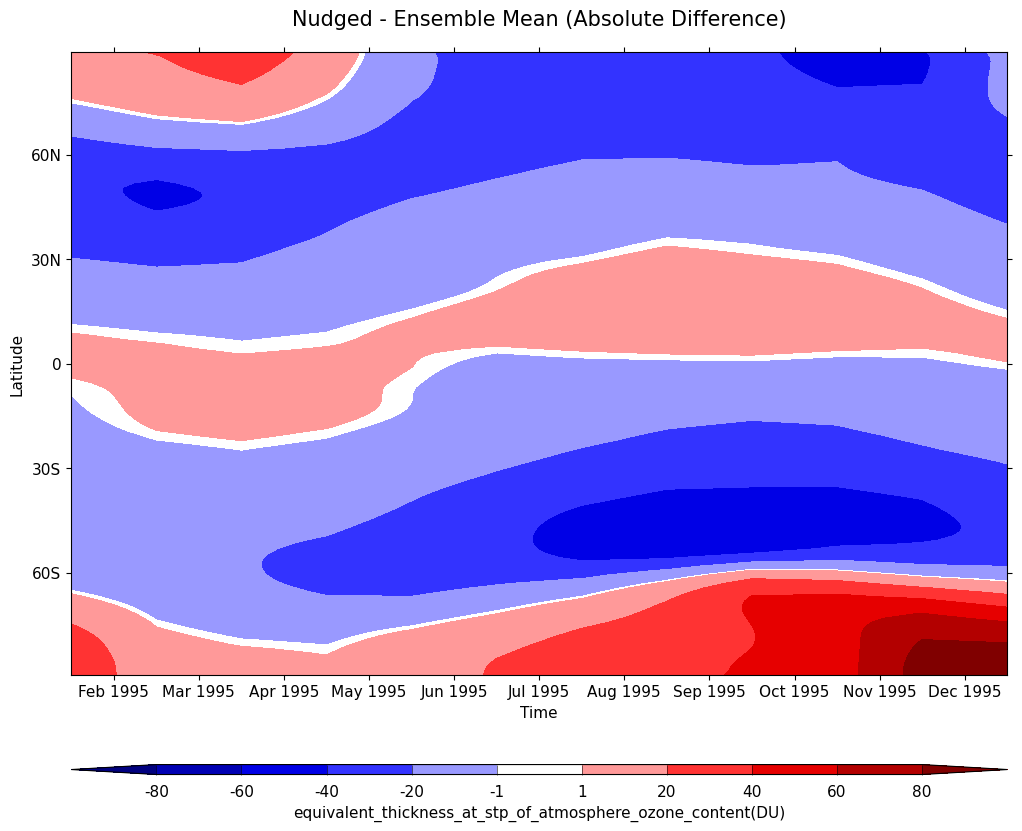

In [9]:
cfp.cscale(scale='BlWhRe')
# set the levels to use
cfp.levs(manual=[-80,-60,-40,-20,-1,1,20,40,60,80])
cfp.con(abs_zm, lines=False, swap_axes=True, title='Nudged - Ensemble Mean (Absolute Difference)')

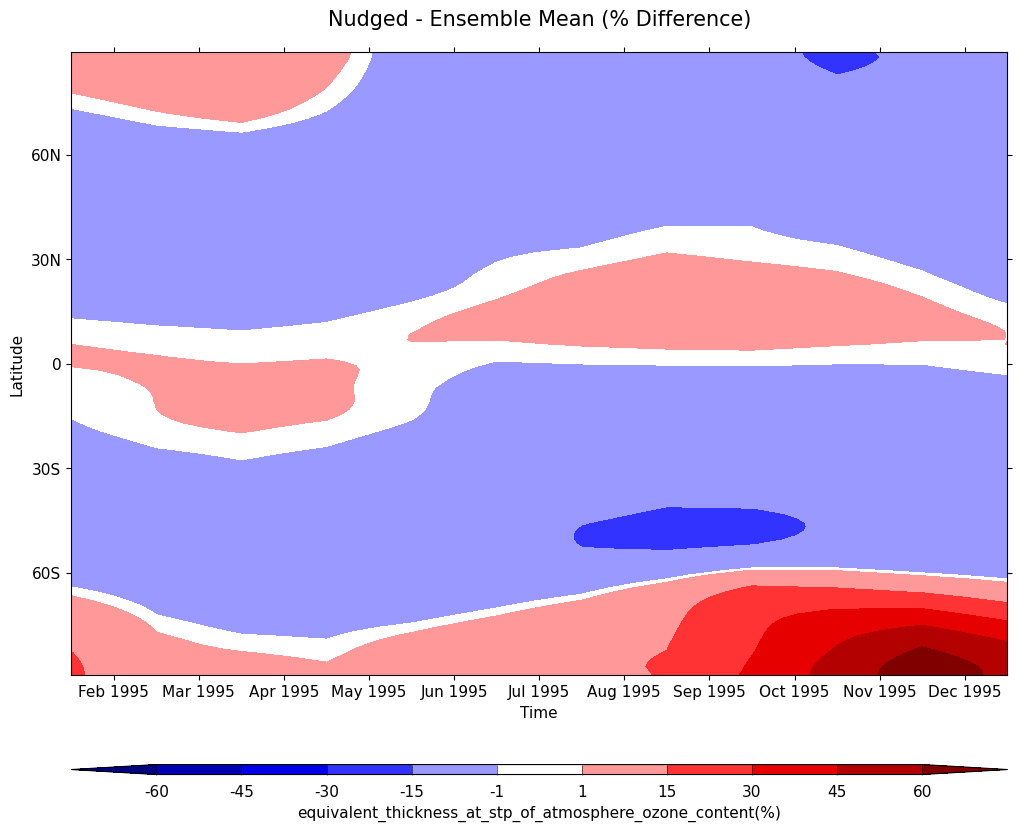

In [10]:
# set the levels to use
cfp.levs(manual=[-60,-45,-30,-15,-1,1,15,30,45,60])
cfp.con(pc_zm, lines=False, swap_axes=True, title='Nudged - Ensemble Mean (% Difference)')

In [11]:
# reset levels back to automatic
cfp.levs()

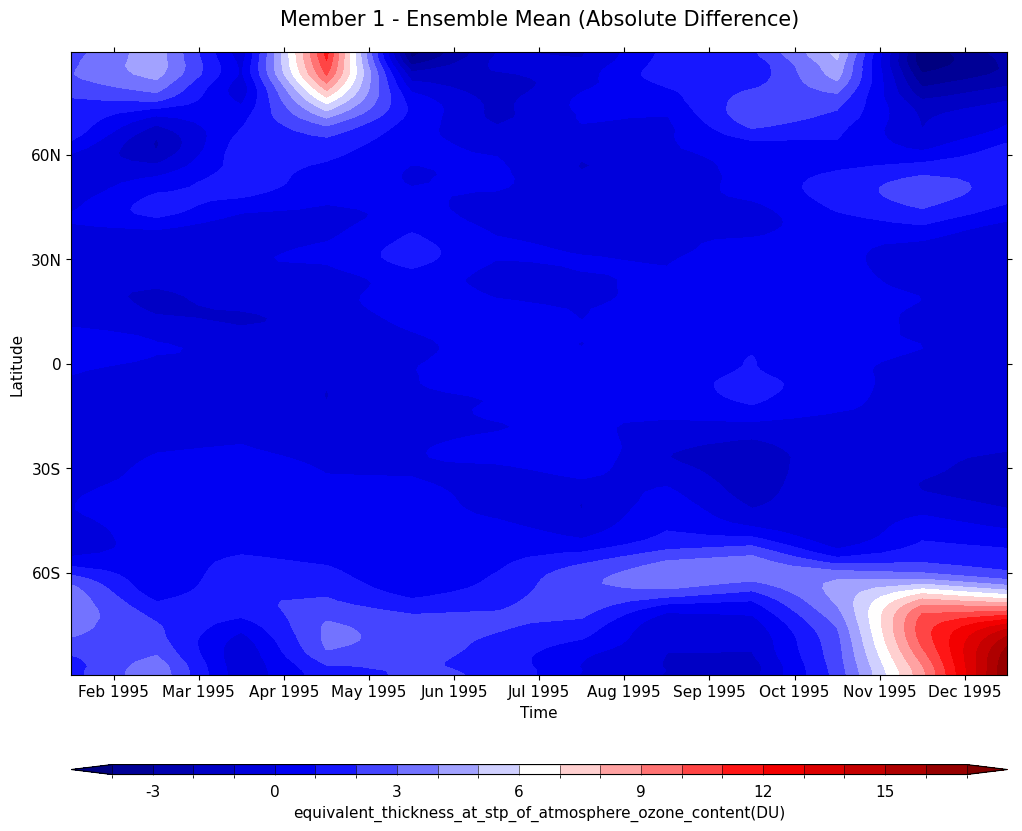

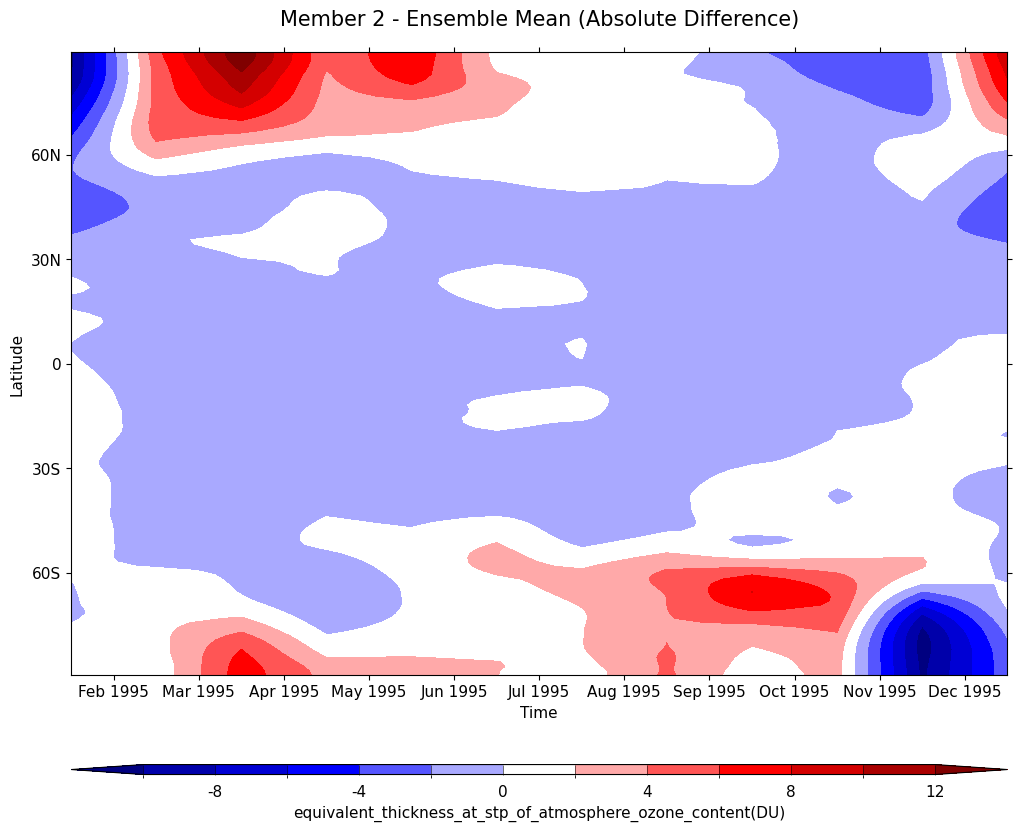

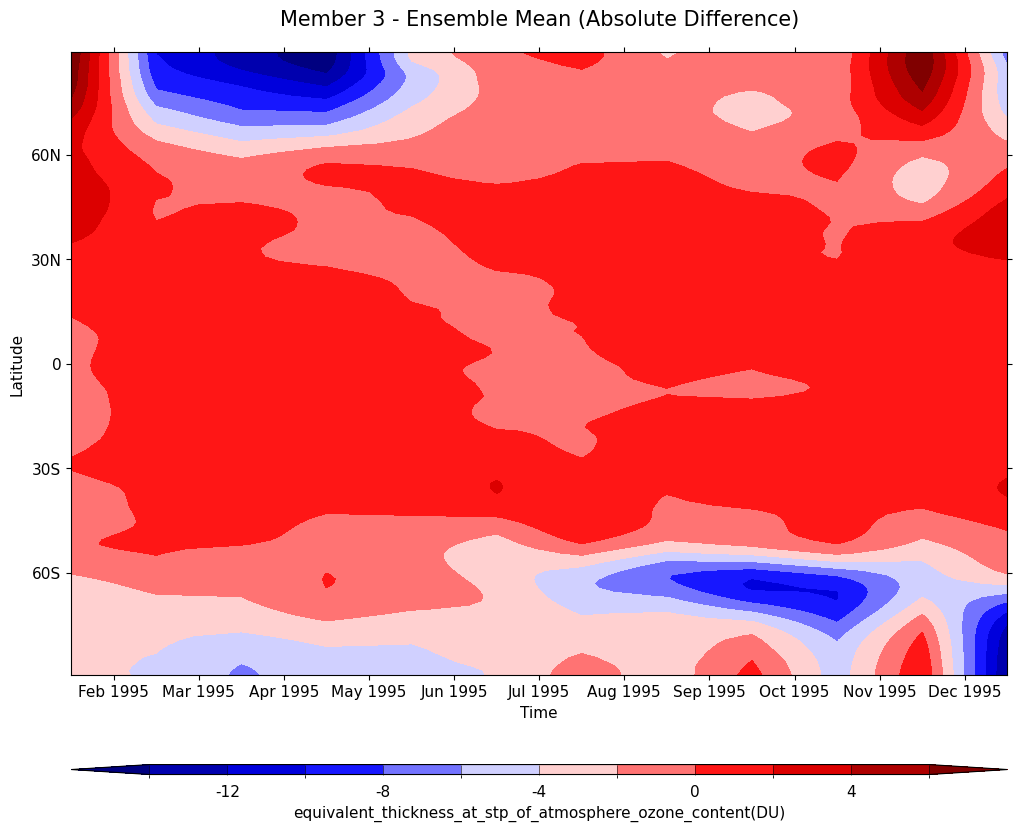

In [12]:
i=0
# plot the data
for f in ens_abs:
    i += 1
    cfp.con(f, lines=False, swap_axes=True, title='Member '+str(i)+' - Ensemble Mean (Absolute Difference)')

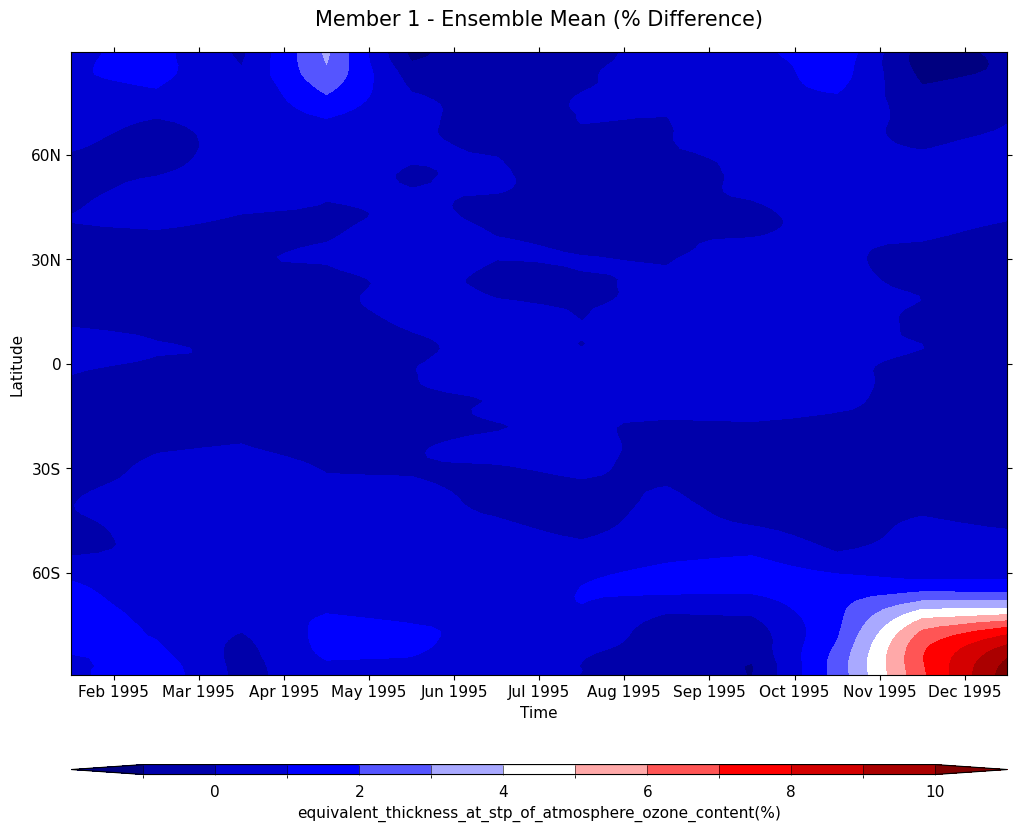

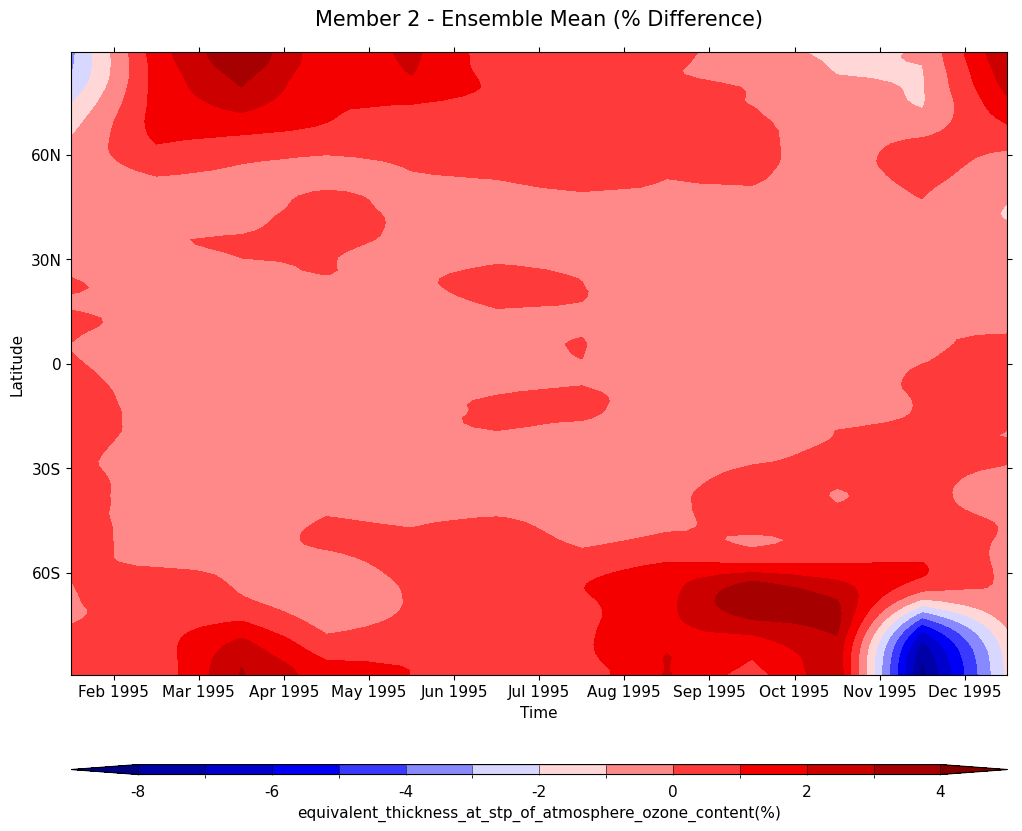

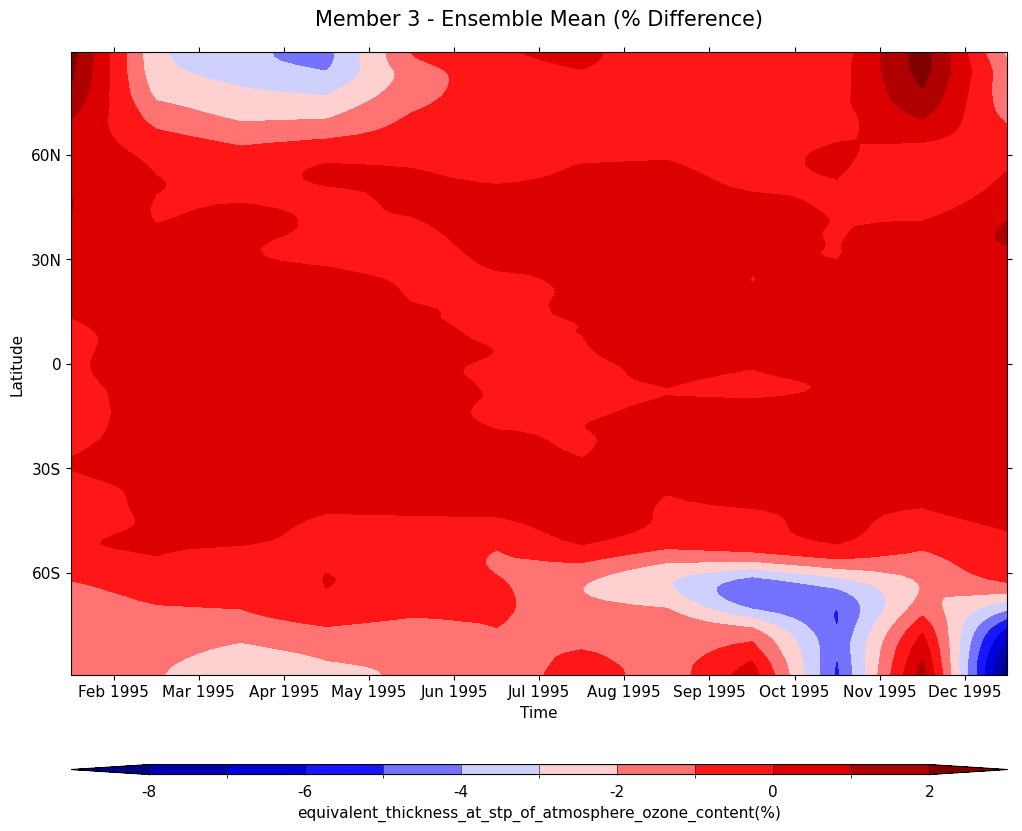

In [13]:
i=0
# plot the data
for f in ens_pc:
    i += 1
    cfp.con(f, lines=False, swap_axes=True, title='Member '+str(i)+' - Ensemble Mean (% Difference)')